In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/7791.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/8401.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5761.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/8451.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5511.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/2721.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/2921.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/371.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5671.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5421.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/4061.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/4751.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/1891.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/7851.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blue

In [2]:
#!pip install imagecodecs

In [3]:
!pip install tensorflow tifffile opencv-python
import tifffile as tiff

In [4]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
RED_BAND_ID = 3  # Red band
RED_BAND_FOLDER = "redband"  # Folder name for red band

def load_red_band_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, RED_BAND_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        files = [f for f in os.listdir(band_path) if f.lower().endswith(".tif")]
        print(f"\n{label.upper()} — Found {len(files)} red band images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)
                img = tiff.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                img = img.astype(np.float32).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} red band images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_red, y_red = load_red_band_dataset()  # From your red band loader
print("✅ Final dataset shape:", X_red.shape, y_red.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 red band images


Loading norust: 100%|██████████| 819/819 [00:00<00:00, 819.63it/s]



RUST — Found 848 red band images


Loading rust: 100%|██████████| 848/848 [00:01<00:00, 804.99it/s]



✅ Finished loading: 1667 red band images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [5]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image before NDRE computation
SELECTED_BANDS = [4, 5]  # RedEdge (4), NIR (5)

BAND_FOLDERS = {
    0: "rgb",
    1: "blueband",
    2: "greenband",
    3: "redband",
    4: "rededgeband",
    5: "nir"
}

def compute_ndre_image(rededge, nir):
    # Compute NDRE = (NIR - RedEdge) / (NIR + RedEdge)
    ndre = (nir - rededge) / (nir + rededge + 1e-6)
    ndre = np.clip(ndre, -1, 1)
    return ndre.reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

def load_ndre_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_files = {band_id: {} for band_id in SELECTED_BANDS}

        for band_id in SELECTED_BANDS:
            band_path = os.path.join(DATA_DIR, BAND_FOLDERS[band_id], label)
            if not os.path.exists(band_path):
                raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

            for f in os.listdir(band_path):
                ext = f.lower().split('.')[-1]
                if band_id == 0 and ext not in ["jpg", "jpeg", "png"]:
                    continue
                elif band_id != 0 and ext != "tif":
                    continue

                try:
                    base = int(f.split('.')[0])
                    band_files[band_id][base] = os.path.join(band_path, f)
                except:
                    print(f"[WARN] Skipping unreadable filename: {f}")

        # Match samples across bands
        common_bases = set(k - (k % 10) for k in band_files[SELECTED_BANDS[0]].keys())
        for band_id in SELECTED_BANDS[1:]:
            common_bases &= set(k - (k % 10) for k in band_files[band_id].keys())

        print(f"\n{label.upper()} — Found {len(common_bases)} complete sample sets")

        for base in tqdm(sorted(common_bases), desc=f"Loading {label}"):
            try:
                band_images = {}
                for band_id in SELECTED_BANDS:
                    file_id = base + band_id
                    file_path = band_files[band_id].get(file_id, None)
                    if file_path is None:
                        raise FileNotFoundError(f"[MISSING] {file_id} in band {BAND_FOLDERS[band_id]}")

                    img = tiff.imread(file_path)
                    img = cv2.resize(img, IMAGE_SIZE)
                    band_images[band_id] = img.astype(np.float32)

                rededge = band_images[4]
                nir = band_images[5]

                ndre_img = compute_ndre_image(rededge, nir)
                X.append(ndre_img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping sample base {base}: {e}")

    print(f"\n✅ Finished loading: {len(X)} images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_ndre, y_ndre = load_ndre_dataset()  # From your NDRE loader
print("✅ Final dataset shape:", X_ndre.shape, y_ndre.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 complete sample sets


Loading norust: 100%|██████████| 819/819 [00:02<00:00, 400.75it/s]



RUST — Found 848 complete sample sets


Loading rust: 100%|██████████| 848/848 [00:02<00:00, 401.93it/s]



✅ Finished loading: 1667 images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2025-08-29 09:57:31.079828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756461451.102678    7114 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756461451.109640    7114 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
assert len(X_red) == len(X_ndre) == len(y_red) == len(y_ndre), "Mismatch in dataset lengths"
assert np.array_equal(y_red, y_ndre), "Label mismatch"

In [8]:
y = y_red  # or y_ndvi, since they are same

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Normalize inputs
X_red = X_red / 255.0
X_ndre = X_ndre / 1.0  # Already in [-1, 1]

# Convert labels to categorical
y_cat = to_categorical(y, num_classes=2)

# Step 1: Split into 80% train+val, 20% test
Xr_temp, Xr_test, Xn_temp, Xn_test, y_temp, y_test = train_test_split(
    X_red, X_ndre, y_cat, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Split 80% part into 70% train, 10% val
# 10 / 80 = 0.125 → 12.5% of train_val becomes validation
Xr_train, Xr_val, Xn_train, Xn_val, y_train, y_val = train_test_split(
    Xr_temp, Xn_temp, y_temp, test_size=0.125, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

In [10]:
print("🔴 RED Band Shapes:")
print("Train:", Xr_train.shape)
print("Val:  ", Xr_val.shape)
print("Test: ", Xr_test.shape)

print("\n🌿 NDRE Shapes:")
print("Train:", Xn_train.shape)
print("Val:  ", Xn_val.shape)
print("Test: ", Xn_test.shape)

print("\n🏷️ Label Shapes:")
print("Train:", y_train.shape)
print("Val:  ", y_val.shape)
print("Test: ", y_test.shape)

🔴 RED Band Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🌿 NDRE Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🏷️ Label Shapes:
Train: (1166, 2)
Val:   (167, 2)
Test:  (334, 2)


In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# === Define CNN model for grayscale RGB ===
def build_red_branch(input_shape):
    input_red = Input(shape=input_shape)  # (224,224,1) since grayscale
    x = Conv2D(32, (3, 3), activation='relu')(input_red)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.8)(x)
    return input_red, x

# === Define CNN model for NDVI ===
def build_ndre_branch(input_shape):
    input_ndre = Input(shape=input_shape)  # (224,224,1)
    x = Conv2D(32, (3, 3), activation='relu')(input_ndre)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.8)(x)
    return input_ndre, x

# === Build branches ===
input_red, red_branch = build_red_branch((224, 224, 1))
input_ndre, ndre_branch = build_ndre_branch((224, 224, 1))

# === Merge branches ===
merged = Concatenate()([red_branch, ndre_branch])
x = Dense(128, activation='relu')(merged)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax')(x)

# === Final model ===
model = Model(inputs=[input_red, input_ndre], outputs=output)

I0000 00:00:1756461455.088398    7114 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756461455.089070    7114 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [12]:
from tensorflow.keras.optimizers import Adam
# Set custom learning rate
lr = 0.0001  # example value

optimizer = Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 222, 222,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 111, 111,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 109, 109,  │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 54, 54,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 93312)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 93312)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 11,944,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │ 11,944,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,940,418 (91.33 MB)

 Trainable params: 23,940,418 (91.33 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    [Xr_train, Xn_train], y_train,
    validation_data=([Xr_val, Xn_val], y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20


I0000 00:00:1756461460.494137    7169 service.cc:148] XLA service 0x7ccf40002390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756461460.494185    7169 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756461460.494193    7169 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756461460.840651    7169 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/37 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3906 - loss: 1.8189

I0000 00:00:1756461465.379290    7169 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.5239 - loss: 1.2904 - val_accuracy: 0.8503 - val_loss: 0.4683
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7082 - loss: 0.7064 - val_accuracy: 0.8623 - val_loss: 0.4053
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7383 - loss: 0.5260 - val_accuracy: 0.8802 - val_loss: 0.3680
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7918 - loss: 0.4986 - val_accuracy: 0.8623 - val_loss: 0.3744
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7485 - loss: 0.5595 - val_accuracy: 0.8563 - val_loss: 0.3446
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7655 - loss: 0.5011 - val_accuracy: 0.8743 - val_loss: 0.3513
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7727 - loss: 0.4714 - val_accuracy: 0.8802 - val_loss: 0.3283
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7642 - loss: 0.4723 - val_accuracy: 0.8862 - val_loss: 

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step

--- Train Set Metrics ---
Accuracy : 0.8551
Precision: 0.8003
Recall   : 0.9528
F1 Score : 0.8699
ROC AUC  : 0.9299

Classification Report:
              precision    recall  f1-score   support

      norust       0.94      0.75      0.84       573
        rust       0.80      0.95      0.87       593

    accuracy                           0.86      1166
   macro avg       0.87      0.85      0.85      1166
weighted avg       0.87      0.86      0.85      1166



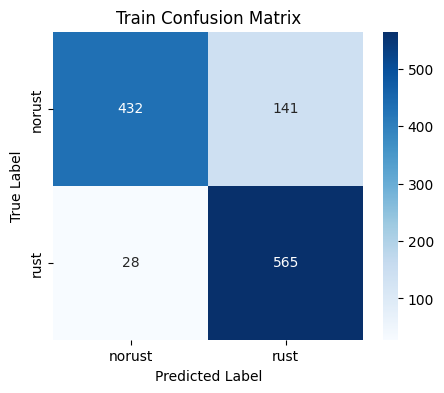

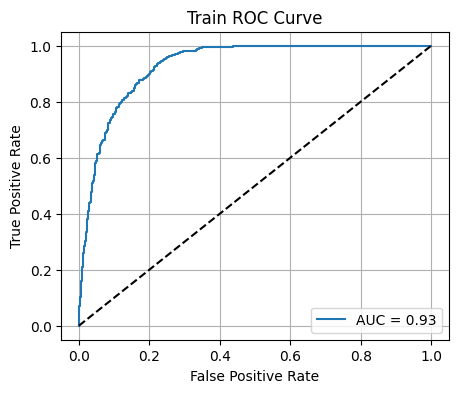

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

--- Test Set Metrics ---
Accuracy : 0.8323
Precision: 0.7850
Recall   : 0.9235
F1 Score : 0.8486
ROC AUC  : 0.8798

Classification Report:
              precision    recall  f1-score   support

      norust       0.90      0.74      0.81       164
        rust       0.79      0.92      0.85       170

    accuracy                           0.83       334
   macro avg       0.84      0.83      0.83       334
weighted avg       0.84      0.83      0.83       334



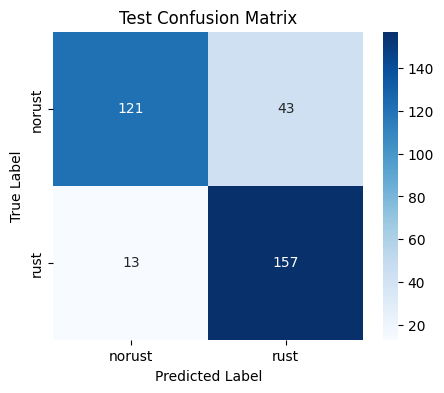

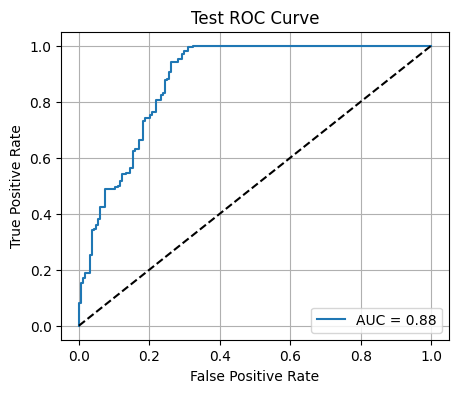

In [14]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, X_red, X_ndre, y_true, set_name="Set"):
    # Predict probabilities
    y_pred_prob = model.predict([X_red, X_ndre])

    # If y_true is one-hot encoded, convert to class index
    if y_true.ndim == 2 and y_true.shape[1] == 2:
        y_true = np.argmax(y_true, axis=1)

    y_pred = np.argmax(y_pred_prob, axis=1)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob[:, 1])

    # Print metrics
    print(f"\n--- {set_name} Set Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["norust", "rust"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["norust", "rust"],
                yticklabels=["norust", "rust"])
    plt.title(f"{set_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# ✅ Example usage:
evaluate_model(model, Xr_train, Xn_train, y_train, set_name="Train")
evaluate_model(model, Xr_test, Xn_test, y_test, set_name="Test")